ChArUco 검출 결과:
  이미지 1: 70개 코너
  이미지 2: 62개 코너
  매칭된 코너: 55개
새로운 인터페이스로 매칭 결과 시각화:


/var/folders/00/g8qdvht528xc9srh5br0f6jc0000gn/T/ipykernel_57803/1514355168.py:170: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', len(matches))


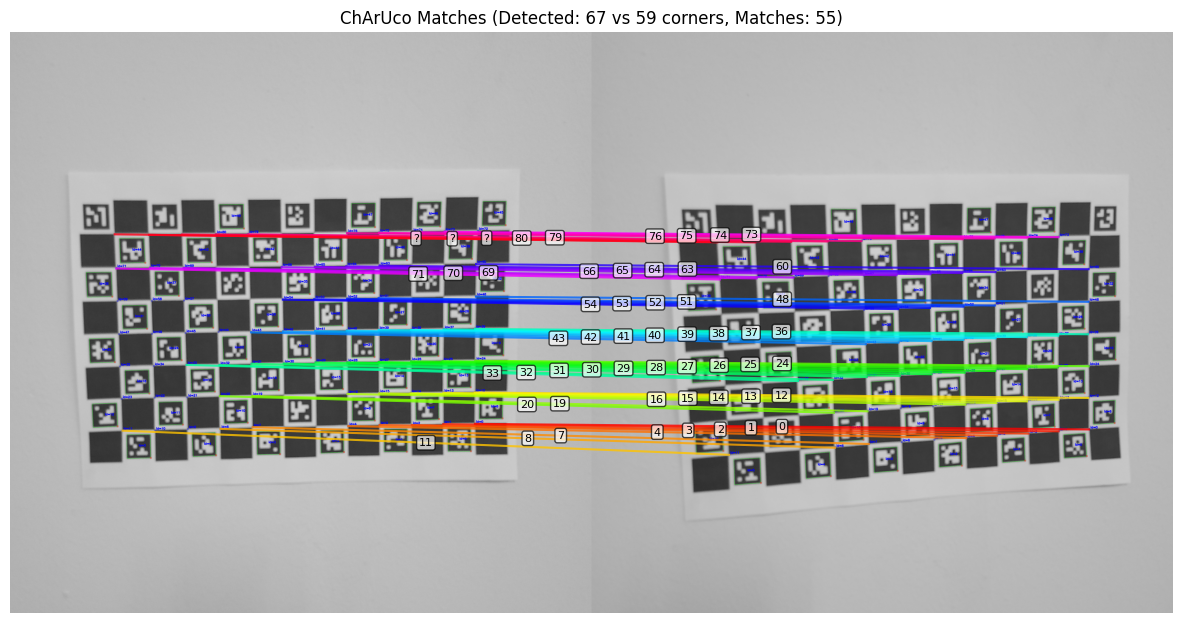

In [1]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def sift_match_for_visualize(img1, img2):
    """ChArUco 패턴을 사용한 이미지 간 특징점 매칭"""

    """ChArUco 보드 생성"""
    squares_x, squares_y = 13, 9
    square_length = 0.02
    marker_length = 0.01
    dict_type = cv2.aruco.DICT_5X5_100
    
    aruco_dict = cv2.aruco.getPredefinedDictionary(dict_type)
    board = cv2.aruco.CharucoBoard(
        (squares_x, squares_y),
        square_length,
        marker_length,
        aruco_dict
    )

    detector = cv2.aruco.ArucoDetector(aruco_dict)
    
    # 첫 번째 이미지에서 ChArUco 검출
    marker_corners1, marker_ids1, _ = detector.detectMarkers(img1)
    ret1, charuco_corners1, charuco_ids1 = cv2.aruco.interpolateCornersCharuco(
        marker_corners1, marker_ids1, img1, board
    )
    
    # 두 번째 이미지에서 ChArUco 검출
    marker_corners2, marker_ids2, _ = detector.detectMarkers(img2)
    ret2, charuco_corners2, charuco_ids2 = cv2.aruco.interpolateCornersCharuco(
        marker_corners2, marker_ids2, img2, board
    )
    
    # 이미지 간 매칭 수행
    good_matches = []
    matched_ids = []
    
    if ret1 > 0 and ret2 > 0:
        ids1_flat = charuco_ids1.flatten()
        ids2_flat = charuco_ids2.flatten()
        
        # 공통 ID 찾기
        for i, id1 in enumerate(ids1_flat):
            for j, id2 in enumerate(ids2_flat):
                if id1 == id2:
                    pt1 = tuple(charuco_corners1[i][0])
                    pt2 = tuple(charuco_corners2[j][0])
                    good_matches.append((pt1, pt2))  # 이미지1 픽셀 ↔ 이미지2 픽셀
                    matched_ids.append(id1)
                    break
    
    detection_info = {
        'img1': {
            'marker_corners': marker_corners1,
            'marker_ids': marker_ids1,
            'charuco_corners': charuco_corners1,
            'charuco_ids': charuco_ids1,
            'num_corners': ret1
        },
        'img2': {
            'marker_corners': marker_corners2,
            'marker_ids': marker_ids2,
            'charuco_corners': charuco_corners2,
            'charuco_ids': charuco_ids2,
            'num_corners': ret2
        }
    }
    
    return good_matches, matched_ids, detection_info

def draw_sift_matches(img1, img2, matches):
    """
    ChArUco 매칭 결과 시각화 (SIFT 호환 인터페이스)
    함수 내부에서 ChArUco 검출을 수행하고 매칭 결과와 함께 표시
    """
    # ChArUco 보드 생성 및 검출
    """ChArUco 보드 생성"""
    squares_x, squares_y = 13, 9
    square_length = 0.04
    marker_length = 0.02
    dict_type = cv2.aruco.DICT_5X5_50
    
    aruco_dict = cv2.aruco.getPredefinedDictionary(dict_type)
    board = cv2.aruco.CharucoBoard(
        (squares_x, squares_y),
        square_length,
        marker_length,
        aruco_dict
    )
    detector = cv2.aruco.ArucoDetector(aruco_dict)
    
    # 이미지에서 ChArUco 검출
    marker_corners1, marker_ids1, _ = detector.detectMarkers(img1)
    ret1, charuco_corners1, charuco_ids1 = cv2.aruco.interpolateCornersCharuco(
        marker_corners1, marker_ids1, img1, board
    )
    
    marker_corners2, marker_ids2, _ = detector.detectMarkers(img2)
    ret2, charuco_corners2, charuco_ids2 = cv2.aruco.interpolateCornersCharuco(
        marker_corners2, marker_ids2, img2, board
    )
    
    # 입력받은 매칭에서 해당하는 ID 찾기 (근사 매칭)
    matched_ids = []
    if ret1 > 0 and ret2 > 0:
        ids1_flat = charuco_ids1.flatten()
        ids2_flat = charuco_ids2.flatten()
        
        for (x1, y1), (x2, y2) in matches:
            best_id = -1
            min_dist = float('inf')
            
            # 첫 번째 이미지에서 가장 가까운 ChArUco 코너 찾기
            for i, id1 in enumerate(ids1_flat):
                corner1 = charuco_corners1[i][0]
                dist = np.sqrt((corner1[0] - x1)**2 + (corner1[1] - y1)**2)
                if dist < min_dist and dist < 5.0:  # 5픽셀 이내
                    # 두 번째 이미지에서도 같은 ID가 있는지 확인
                    for j, id2 in enumerate(ids2_flat):
                        if id2 == id1:
                            corner2 = charuco_corners2[j][0]
                            dist2 = np.sqrt((corner2[0] - x2)**2 + (corner2[1] - y2)**2)
                            if dist2 < 5.0:  # 5픽셀 이내
                                min_dist = dist
                                best_id = id1
                                break
            
            matched_ids.append(best_id if best_id != -1 else '?')
    else:
        matched_ids = ['?'] * len(matches)
    
    # 캔버스 생성
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    canvas = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2
    
    # 컬러 이미지로 변환
    canvas_color = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
    
    # ChArUco 검출 결과 그리기
    if marker_corners1 is not None and len(marker_corners1) > 0:
        cv2.aruco.drawDetectedMarkers(canvas_color[:h1, :w1], 
                                     marker_corners1, marker_ids1)
    
    if charuco_corners1 is not None and len(charuco_corners1) > 0:
        cv2.aruco.drawDetectedCornersCharuco(canvas_color[:h1, :w1], 
                                           charuco_corners1, charuco_ids1)
    
    if marker_corners2 is not None and len(marker_corners2) > 0:
        cv2.aruco.drawDetectedMarkers(canvas_color[:h2, w1:], 
                                     marker_corners2, marker_ids2)
    
    if charuco_corners2 is not None and len(charuco_corners2) > 0:
        cv2.aruco.drawDetectedCornersCharuco(canvas_color[:h2, w1:], 
                                           charuco_corners2, charuco_ids2)
    
    # 시각화
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(canvas_color, cv2.COLOR_BGR2RGB))
    
    # 매칭선 그리기
    if len(matches) > 0:
        cmap = plt.cm.get_cmap('hsv', len(matches))
        
        for i, ((x1, y1), (x2, y2)) in enumerate(matches):
            color = cmap(i)
            plt.plot([x1, x2 + w1], [y1, y2], color=color, linewidth=1.5, alpha=0.8)
            
            # 매칭 ID 표시
            mid_x = (x1 + x2 + w1) / 2
            mid_y = (y1 + y2) / 2
            plt.text(mid_x, mid_y, str(matched_ids[i]), 
                    fontsize=8, ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7))
    
    # 검출 정보 표시
    corners1_count = ret1 if ret1 > 0 else 0
    corners2_count = ret2 if ret2 > 0 else 0
    
    plt.title(f"ChArUco Matches (Detected: {corners1_count} vs {corners2_count} corners, Matches: {len(matches)})")
    plt.axis('off')
    plt.show()

# 메인 실행 코드
IMAGE_DIR = Path('camera_images3')

# 이미지 로드
img1 = cv2.imread(str(IMAGE_DIR / '0.jpeg'), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(str(IMAGE_DIR / '1.jpeg'), cv2.IMREAD_GRAYSCALE)

# ChArUco 매칭 수행
matches, matched_ids, detection_info = sift_match_for_visualize(img1, img2)

print(f"ChArUco 검출 결과:")
print(f"  이미지 1: {detection_info['img1']['num_corners']}개 코너")
print(f"  이미지 2: {detection_info['img2']['num_corners']}개 코너")
print(f"  매칭된 코너: {len(matches)}개")

# 새로운 3개 매개변수 인터페이스로 테스트
if len(matches) > 0:
    print("새로운 인터페이스로 매칭 결과 시각화:")
    draw_sift_matches(img1, img2, matches)
else:
    print("매칭 결과가 없어 매칭 시각화를 건너뜁니다.")

In [2]:
import numpy as np
np.random.seed(42)

def sift_match(img2):
    """ChArUco 패턴을 사용한 특징점 매칭"""

    """ChArUco 보드 생성"""
    squares_x, squares_y = 13, 9
    square_length = 0.02
    marker_length = 0.01
    dict_type = cv2.aruco.DICT_5X5_100
    
    aruco_dict = cv2.aruco.getPredefinedDictionary(dict_type)
    board = cv2.aruco.CharucoBoard(
        (squares_x, squares_y),
        square_length,
        marker_length,
        aruco_dict
    )

    detector = cv2.aruco.ArucoDetector(aruco_dict)
    
    # 두 번째 이미지에서 ChArUco 검출
    marker_corners2, marker_ids2, _ = detector.detectMarkers(img2)
    ret2, charuco_corners2, charuco_ids2 = cv2.aruco.interpolateCornersCharuco(
        marker_corners2, marker_ids2, img2, board
    )
    
    # 매칭 수행
    good_matches = []
    matched_ids = []
    
    # if ret1 > 0 and ret2 > 0:
    if ret2 > 0:
        # ids1_flat = charuco_ids1.flatten()
        ids2_flat = charuco_ids2.flatten()
        
        world_corners_3d = board.getChessboardCorners()
        
        for i, corner_id in enumerate(charuco_ids2.flatten()):
            # 월드 좌표 (미터 단위, Z=0 평면)
            world_x = world_corners_3d[corner_id][0]
            world_y = world_corners_3d[corner_id][1]
            
            # 이미지 좌표 (픽셀 단위)
            img_u = charuco_corners2[i][0][0]
            img_v = charuco_corners2[i][0][1]
            
            # ((월드_x, 월드_y), (이미지_u, 이미지_v)) 형태로 저장
            good_matches.append(((world_x, world_y), (img_u, img_v)))
            matched_ids.append(corner_id)
    
    detection_info = {

        'img2': {
            'marker_corners': marker_corners2,
            'marker_ids': marker_ids2,
            'charuco_corners': charuco_corners2,
            'charuco_ids': charuco_ids2,
            'num_corners': ret2
        }
    }
    
    return good_matches, matched_ids, detection_info

def compute_homography(matches):
    A = []
    for (x, y), (xp, yp) in matches:
        A.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])
    A = np.array(A)

    # SVD
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    H = h.reshape(3, 3)
    return H / H[2, 2]

def average_reprojection_error(matches, H):
    total_error = 0
    for (x, y), (xp, yp) in matches:
        p = np.array([x, y, 1.0])
        projected = H @ p
        projected /= projected[2]
        error = np.linalg.norm(projected[:2] - np.array([xp, yp]))
        total_error += error
    return total_error / len(matches)

matches, matched_ids, detection_info = sift_match(img2)
H = compute_homography(matches)
error = average_reprojection_error(matches, H)
print(f"Average Reprojection Error: {error:.4f} pixels")

Average Reprojection Error: 3.0322 pixels


RANSAC Homography Inliers: 55 / 55
Average Reprojection Error after RANSAC: 1.6348 pixels


/var/folders/00/g8qdvht528xc9srh5br0f6jc0000gn/T/ipykernel_57803/1514355168.py:170: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', len(matches))


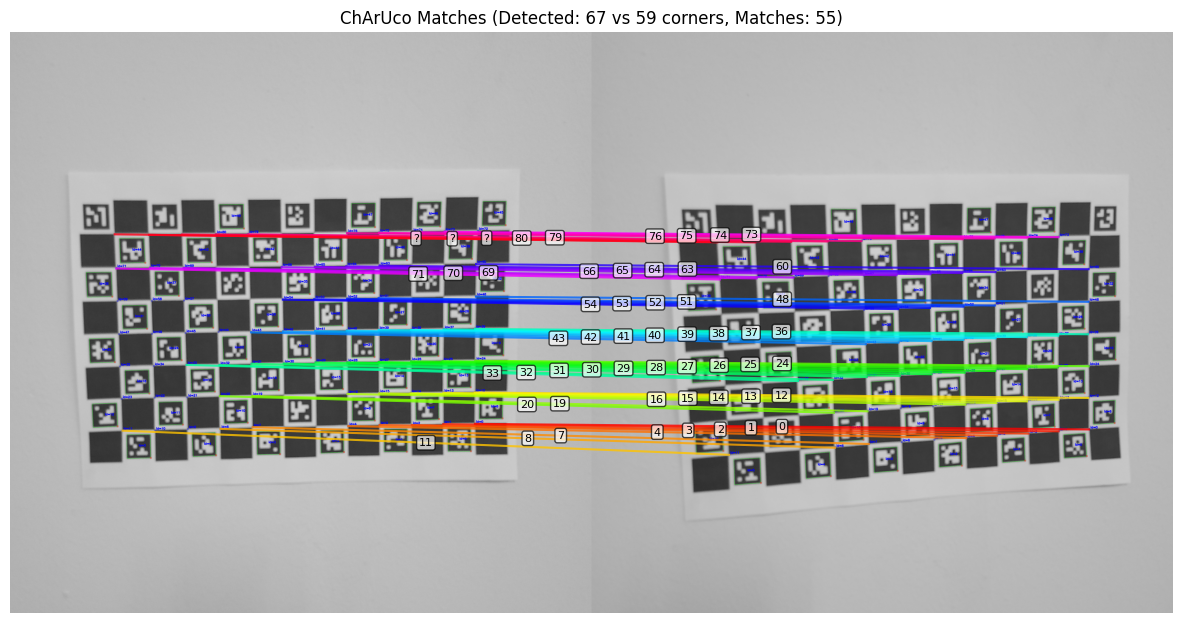

In [3]:
import random
import numpy as np
np.random.seed(42)
random.seed(42)

def ransac_homography(matches, threshold=3.0, iterations=1000):
    best_H = None
    max_inliers = 0
    best_inliers = []

    for _ in range(iterations):
        sample = random.sample(matches, 4)
        H_candidate = compute_homography(sample)
        inliers = []

        for (x, y), (xp, yp) in matches:
            p = np.array([x, y, 1.0])
            projected = H_candidate @ p
            projected /= projected[2]
            error = np.linalg.norm(projected[:2] - np.array([xp, yp]))
            if error < threshold:
                inliers.append(((x, y), (xp, yp)))

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_H = H_candidate
            best_inliers = inliers

    return best_H / best_H[2,2], best_inliers

matches, matched_ids, detection_info = sift_match_for_visualize(img1, img2)
H_ransac, inlier_matches = ransac_homography(matches, threshold=5.0, iterations=1000)
error = average_reprojection_error(inlier_matches, H_ransac)

print(f"RANSAC Homography Inliers: {len(inlier_matches)} / {len(matches)}")
print(f"Average Reprojection Error after RANSAC: {error:.4f} pixels")

draw_sift_matches(img1, img2, inlier_matches)

In [9]:
# 여러 이미지에 대해 Homography 계산
import os
import numpy as np
np.random.seed(42)

filenames = sorted(os.listdir(IMAGE_DIR), key=lambda x: int(x.split('.')[0]))
H_list = []

for i in range(0, len(filenames)):
    img_path =str(IMAGE_DIR / filenames[i])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    matches, kp1, kp2 = sift_match(img)
    print(f"Matching image{i}: {len(matches)} good matches")

    H_ransac, inlier_matches = ransac_homography(matches, threshold=5.0, iterations=1000)
    error = average_reprojection_error(inlier_matches, H_ransac)

    H_list.append(H_ransac)

    print(f"RANSAC Homography for image0 and image{i}:")
    print(f"Inliers: {len(inlier_matches)} / {len(matches)}")
    print(f"Average Reprojection Error: {error:.4f} pixels\n")
    # print(f'det H: {np.linalg.det(H_ransac):.6f}')
    # print(f"Homography Matrix for image{i}:\n{H_ransac}\n")

Matching image0: 70 good matches
RANSAC Homography for image0 and image0:
Inliers: 59 / 70
Average Reprojection Error: 2.8782 pixels

Matching image1: 62 good matches
RANSAC Homography for image0 and image1:
Inliers: 52 / 62
Average Reprojection Error: 2.4428 pixels

Matching image2: 42 good matches
RANSAC Homography for image0 and image2:
Inliers: 33 / 42
Average Reprojection Error: 2.6103 pixels

Matching image3: 66 good matches
RANSAC Homography for image0 and image3:
Inliers: 59 / 66
Average Reprojection Error: 2.4064 pixels

Matching image4: 42 good matches
RANSAC Homography for image0 and image4:
Inliers: 30 / 42
Average Reprojection Error: 2.9524 pixels

Matching image5: 63 good matches
RANSAC Homography for image0 and image5:
Inliers: 47 / 63
Average Reprojection Error: 2.6729 pixels

Matching image6: 68 good matches
RANSAC Homography for image0 and image6:
Inliers: 64 / 68
Average Reprojection Error: 2.4985 pixels

Matching image7: 58 good matches
RANSAC Homography for image0 

In [10]:
import numpy as np
np.random.seed(42)

def compute_v_ij(H, i, j):
    return np.array([
        H[0, i]*H[0, j],
        H[0, i]*H[1, j] + H[1, i]*H[0, j],
        H[1, i]*H[1, j],
        H[2, i]*H[0, j] + H[0, i]*H[2, j],
        H[2, i]*H[1, j] + H[1, i]*H[2, j],
        H[2, i]*H[2, j]
    ])

def estimate_intrinsics(H_list):
    
    V = []
    for H in H_list:
        v12 = compute_v_ij(H, 0, 1)
        v11 = compute_v_ij(H, 0, 0)
        v22 = compute_v_ij(H, 1, 1)
        V.append(v12)
        V.append(v11 - v22)
    V = np.array(V)

    # Solve Vb = 0 using SVD
    _, _, Vt = np.linalg.svd(V)
    b = Vt[-1, :]

    # Extract parameters from b
    B11, B12, B22, B13, B23, B33 = b
    v0 = (B12*B13 - B11*B23) / (B11*B22 - B12**2)
    lam = B33 - (B13**2 + v0*(B12*B13 - B11*B23)) / B11
    alpha = np.sqrt(lam / B11)
    beta = np.sqrt(lam * B11 / (B11*B22 - B12**2))
    gamma = -B12 * alpha**2 * beta / lam
    u0 = gamma * v0 / beta - B13 * alpha**2 / lam

    # Construct K matrix
    K = np.array([
        [alpha, gamma, u0],
        [0,     beta,  v0],
        [0,     0,     1]
    ])
    return K

def estimate_extrinsics(H, K):
    K_inv = np.linalg.inv(K)
    h1 = H[:, 0]
    h2 = H[:, 1]
    h3 = H[:, 2]

    lambda_ = 1.0 / np.linalg.norm(K_inv @ h1)
    r1 = lambda_ * (K_inv @ h1)
    r2 = lambda_ * (K_inv @ h2)
    r3 = np.cross(r1, r2)
    t = lambda_ * (K_inv @ h3)

    # Ensure R is a valid rotation matrix using orthonormalization (SVD)
    R = np.stack([r1, r2, r3], axis=1)
    U, _, Vt = np.linalg.svd(R)
    R_orthonormal = U @ Vt

    return R_orthonormal, t

def is_valid_homography(H, cond_thresh=1e6):
    return (
        np.isfinite(H).all() and 
        np.abs(H[2, 2] - 1.0) < 1e-3 and 
        np.linalg.cond(H) < cond_thresh
    )

def estimate_extrinsics_safe(H_list, K, cond_thresh=1e8):
    extrinsics = []
    for i, H in enumerate(H_list):
        if not is_valid_homography(H, cond_thresh):
            print(f"⚠️ Skipping H[{i}] due to high condition number: {np.linalg.cond(H):.2e}")
            continue
        try:
            R, t = estimate_extrinsics(H, K)
            if R is not None:
                extrinsics.append((R, t))
        except np.linalg.LinAlgError:
            print(f"⚠️ SVD failed for H[{i}]")
    return extrinsics

K = estimate_intrinsics(H_list)
print("Estimated Intrinsic Matrix K:\n", K)

# First camera's extrinsics (identity for the first camera)
# extrinsics = [(np.eye(3), np.zeros(3))]
extrinsics = []

# Append the extrinsics for the other cameras
for idx, H in enumerate(H_list):
    # if idx == 0:
        # continue  # Skip the first camera
    R, t = estimate_extrinsics(H, K)
    print(f"Image {idx+2}:")
    print("Rotation Matrix R:\n", R)
    print("Translation Vector t:\n", t)
    print()
    extrinsics.append((R, t))


Estimated Intrinsic Matrix K:
 [[ 2.88663573e+03 -7.25704307e+00  1.45165119e+03]
 [ 0.00000000e+00  2.88146021e+03  1.57523622e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Image 2:
Rotation Matrix R:
 [[-0.99947584 -0.01194576 -0.03008882]
 [ 0.01468049 -0.99561624 -0.09237312]
 [-0.02885345 -0.09276642  0.99526975]]
Translation Vector t:
 [0.13516168 0.07400395 0.35806344]

Image 3:
Rotation Matrix R:
 [[-0.99171463 -0.0347858  -0.12366096]
 [ 0.04363798 -0.99661927 -0.06961153]
 [-0.1208214  -0.07443108  0.98987989]]
Translation Vector t:
 [0.15666929 0.0769211  0.35731275]

Image 4:
Rotation Matrix R:
 [[-0.87633751 -0.02276204 -0.48115949]
 [ 0.05550128 -0.99700163 -0.05391988]
 [-0.47848947 -0.07395698  0.87497325]]
Translation Vector t:
 [0.1741167  0.06557854 0.41078791]

Image 5:
Rotation Matrix R:
 [[-0.9577483  -0.01542559  0.28719374]
 [-0.00971054 -0.99625699 -0.0858936 ]
 [ 0.28744374 -0.08505326  0.95401365]]
Translation Vector t:
 [0.10738823 0.07753343 0.31

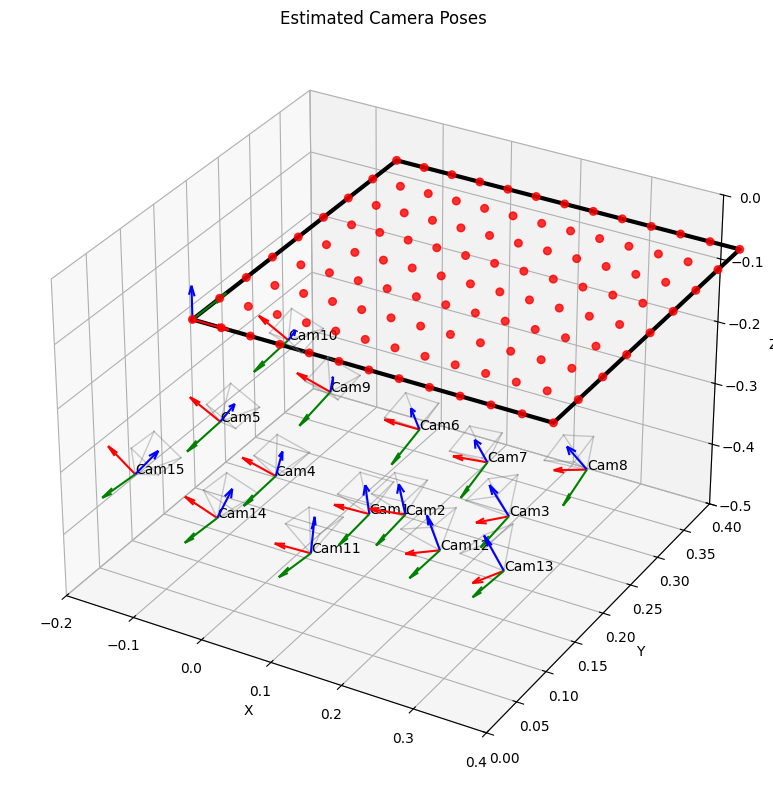

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
np.random.seed(42)

def plot_camera_frustum(ax, R, camera_center, scale):
    """
    카메라 프러스텀(시야각)을 시각화하는 함수
    """
    # 프러스텀 크기
    frustum_length = scale * 1.5
    frustum_width = scale * 0.8
    frustum_height = scale * 0.6
    
    # 프러스텀 모서리 점들 (카메라 좌표계에서)
    frustum_points_local = np.array([
        [0, 0, 0],  # 카메라 중심
        [-frustum_width, -frustum_height, frustum_length],  # 좌하
        [frustum_width, -frustum_height, frustum_length],   # 우하
        [frustum_width, frustum_height, frustum_length],    # 우상
        [-frustum_width, frustum_height, frustum_length]    # 좌상
    ])
    
    # 월드 좌표계로 변환
    frustum_points_world = []
    for point in frustum_points_local:
        world_point = R @ point + camera_center
        frustum_points_world.append(world_point)
    
    frustum_points_world = np.array(frustum_points_world)
    
    # 프러스텀 선 그리기
    # 카메라 중심에서 각 모서리로
    for i in range(1, 5):
        ax.plot([frustum_points_world[0, 0], frustum_points_world[i, 0]],
                [frustum_points_world[0, 1], frustum_points_world[i, 1]],
                [frustum_points_world[0, 2], frustum_points_world[i, 2]], 
                'gray', alpha=0.4, linewidth=1)
    
    # 프러스텀 사각형 그리기
    for i in range(1, 5):
        next_i = i + 1 if i < 4 else 1
        ax.plot([frustum_points_world[i, 0], frustum_points_world[next_i, 0]],
                [frustum_points_world[i, 1], frustum_points_world[next_i, 1]],
                [frustum_points_world[i, 2], frustum_points_world[next_i, 2]], 
                'gray', alpha=0.4, linewidth=1)

# Visualize camera extrinsics in 3D space
def plot_camera_poses(K, extrinsics):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # ChArUco 보드 그리기
    squares_x, squares_y = 13, 9
    square_length = 0.04
    
    # 체커보드 코너점들
    x_coords, y_coords, z_coords = [], [], []
    for i in range(squares_x):
        for j in range(squares_y):
            x_coords.append(i * square_length)
            y_coords.append(j * square_length)
            z_coords.append(0)
    
    ax.scatter(x_coords, y_coords, z_coords, c='red', s=30, alpha=0.8)
    
    # 보드 경계
    max_x = (squares_x - 1) * square_length
    max_y = (squares_y - 1) * square_length
    boundary_x = [0, max_x, max_x, 0, 0]
    boundary_y = [0, 0, max_y, max_y, 0]
    boundary_z = [0, 0, 0, 0, 0]
    ax.plot(boundary_x, boundary_y, boundary_z, 'k-', linewidth=3)

    # World coordinate axes (스케일 조정)
    ax.quiver(0, 0, 0, 0.1, 0, 0, color='r', length=0.5)
    ax.quiver(0, 0, 0, 0, 0.1, 0, color='g', length=0.5)
    ax.quiver(0, 0, 0, 0, 0, 0.1, color='b', length=0.5)

    for idx, (R, t) in enumerate(extrinsics):
        # Camera center in world coordinates
        C = -R.T @ t

        # Draw camera axis (스케일 조정)
        cam_axis = R.T
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 0], cam_axis[1, 0], cam_axis[2, 0], color='r', length=0.05)
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 1], cam_axis[1, 1], cam_axis[2, 1], color='g', length=0.05)
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 2], cam_axis[1, 2], cam_axis[2, 2], color='b', length=0.05)

        ax.text(C[0], C[1], C[2], f"Cam{idx+1}", color='black')

        plot_camera_frustum(ax, R, C, scale=0.03)  # 스케일을 500에서 0.02로 변경

    # 축 범위 설정 (체커보드 중심으로)
    ax.set_xlim(-0.2, 0.4)
    ax.set_ylim(-0.0, 0.4)
    ax.set_zlim(-0.5, 0.0)

    ax.set_title("Estimated Camera Poses")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=30, azim=-60)
    plt.tight_layout()
    plt.show()

plot_camera_poses(K, extrinsics)